In [4]:
import pandas as pd
from pandas import NamedAgg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

In [11]:
df = pd.read_csv("Weather.csv")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              51 non-null     object 
 1   temperature_celsius  51 non-null     float64
 2   humidity             51 non-null     int64  
 3   wind_kph             51 non-null     float64
 4   cloud                51 non-null     int64  
 5   wind_degree          51 non-null     int64  
 6   rain                 51 non-null     int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 2.9+ KB


## Analyze Data Completeness by Country

In [13]:
print("Total countries:", df['country'].nunique())
print("Total records:", len(df))

# compute stats per country
completeness_df = (
    df
    .groupby('country')
    .apply(lambda g: pd.Series({
        "total_records": len(g),
        "avg_completeness": g.notna().mean().mean() * 100,
        "complete_columns": (g.notna().mean() == 1).sum()
    }))
    .reset_index()
)

# sort
completeness_df = completeness_df.sort_values(
    "avg_completeness", ascending=False
)

print(completeness_df.head(10))

best_country = completeness_df.iloc[0]['country']
selected_country = completeness_df.loc[
    completeness_df['total_records'].idxmax(), 'country'
]

print("\nBest completeness:", best_country)
print("Selected for training (most records):", selected_country)


Total countries: 1
Total records: 51
    country  total_records  avg_completeness  complete_columns
0  Bulgaria           51.0             100.0               7.0

Best completeness: Bulgaria
Selected for training (most records): Bulgaria


C:\Users\1000020158\AppData\Local\Temp\ipykernel_27324\2708852271.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


## Filter Data for Bulgaria and Prepare Features

In [17]:
# keep only selected country
df = df[df['country'] == selected_country].copy()

print(f"Using country: {selected_country} | records: {len(df)}")

# features + target
features = [
    "temperature_celsius",
    "humidity",
    "wind_kph",
    "cloud",
    "wind_degree"
]

df['will_rain'] = df['rain'].astype(int)

X = df[features]
y = df['will_rain']

print("Target distribution:\n", y.value_counts())

Using country: Bulgaria | records: 51
Target distribution:
 will_rain
0    27
1    24
Name: count, dtype: int64


## Data Cleaning

In [15]:
# Check for missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
country                0
temperature_celsius    0
humidity               0
wind_kph               0
cloud                  0
wind_degree            0
rain                   0
dtype: int64


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              51 non-null     object 
 1   temperature_celsius  51 non-null     float64
 2   humidity             51 non-null     int64  
 3   wind_kph             51 non-null     float64
 4   cloud                51 non-null     int64  
 5   wind_degree          51 non-null     int64  
 6   rain                 51 non-null     int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 2.9+ KB


In [9]:
df.head()

NameError: name 'df' is not defined

In [21]:
# Drop unnecessary columns - keep only features and target
target_col = 'will_rain'
df = df[features + [target_col]] 
print(f"Dataset shape after dropping unnecessary columns: {df.shape}")
print(f"Remaining columns: {df.columns.tolist()}")

Dataset shape after dropping unnecessary columns: (51, 6)
Remaining columns: ['temperature_celsius', 'humidity', 'wind_kph', 'cloud', 'wind_degree', 'will_rain']


## Data Processing & Feature Engineering
we're deriving the target variable from the precip_mm column:
will_rain = 1  (if precip_mm > 0)
will_rain = 0  (if precip_mm = 0)

In [22]:
# Prepare X (features) and y (target) from cleaned data
X = df[features]
y = df['will_rain']

## Prepare Features and Target Variable

In [23]:
print(f"Features shape: {X.shape}\nTarget shape: {y.shape}\n")
print("Target distribution:\n", y.value_counts())

Features shape: (51, 5)
Target shape: (51,)

Target distribution:
 will_rain
0    27
1    24
Name: count, dtype: int64


In [24]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 40
Testing set size: 11


In [25]:
# Standardize features (important for many ML algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled successfully!")
print(f"Training features mean: {X_train_scaled.mean(axis=0).mean():.4f}")
print(f"Training features std: {X_train_scaled.std(axis=0).mean():.4f}")


Features scaled successfully!
Training features mean: -0.0000
Training features std: 1.0000


## Train the Naive Bayes Model

In [26]:
# Train Naive Bayes classifier
model = GaussianNB()
model.fit(X_train_scaled, y_train)

,"priors priors: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None
,"var_smoothing var_smoothing: float, default=1e-9Portion of the largest variance of all features that is added tovariances for calculation stability... versionadded:: 0.20",1e-09


In [27]:
# Make predictions on test set
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

In [28]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain']))

Model Accuracy: 0.9091 (90.91%)

Classification Report:
              precision    recall  f1-score   support

     No Rain       1.00      0.83      0.91         6
        Rain       0.83      1.00      0.91         5

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.91        11
weighted avg       0.92      0.91      0.91        11



In [29]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
print(f"\nTrue Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")


Confusion Matrix:
[[5 1]
 [0 5]]

True Negatives: 5
False Positives: 1
False Negatives: 0
True Positives: 5


## Model Visualizations

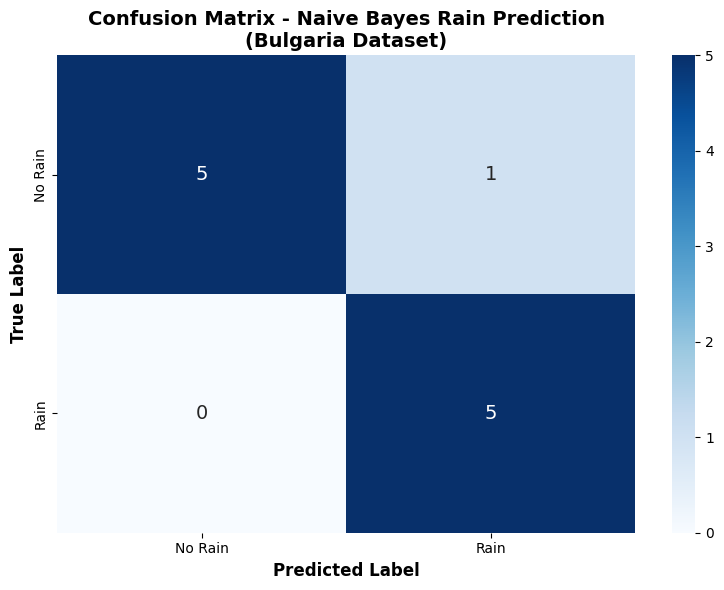


Confusion Matrix Visualization saved!


In [30]:
# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Rain', 'Rain'],
            yticklabels=['No Rain', 'Rain'],
            annot_kws={'fontsize': 14},
            ax=ax)
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Naive Bayes Rain Prediction\n(Bulgaria Dataset)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Visualization saved!")

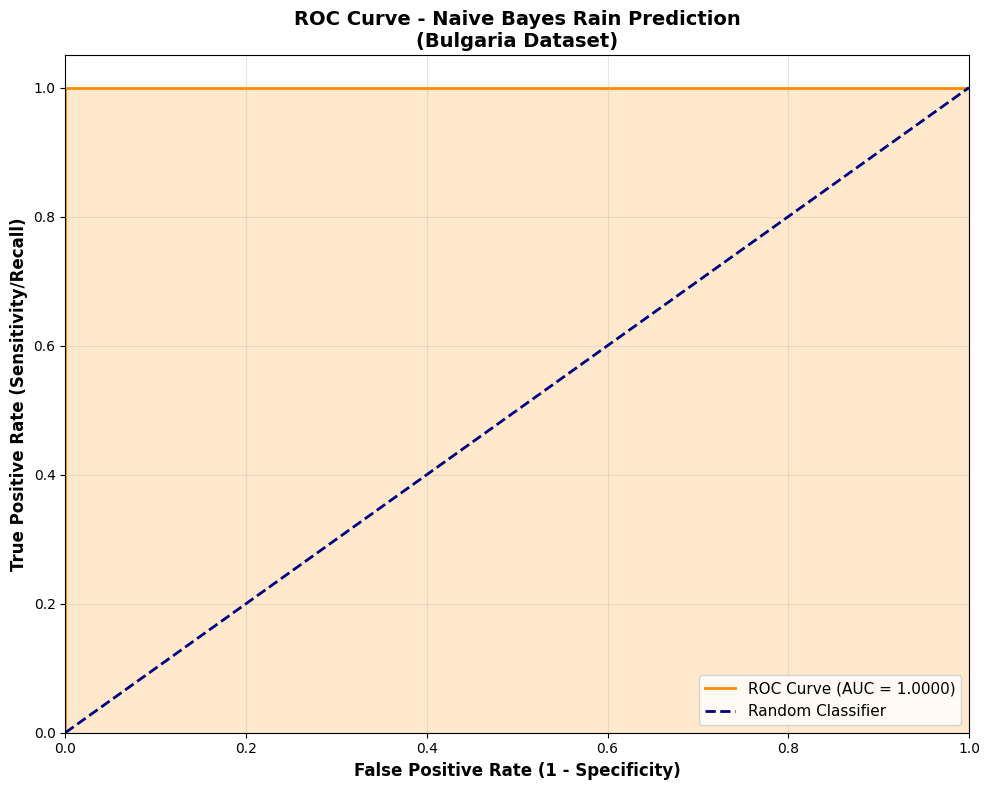


ROC Curve Analysis:
AUC Score: 1.0000


In [31]:
# Calculate ROC Curve and AUC Score
# Get probability of positive class
y_pred_proba_pos = y_pred_proba[:, 1]

# Calculate false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_pos)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.2, color='darkorange')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve - Naive Bayes Rain Prediction\n(Bulgaria Dataset)', 
             fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nROC Curve Analysis:")
print(f"AUC Score: {roc_auc:.4f}")

## Summary of Model Performance

In [32]:
# Extract detailed metrics from classification report
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

# Create performance summary
print("\n" + "="*70)
print("NAIVE BAYES RAIN PREDICTION MODEL - PERFORMANCE SUMMARY")
print("="*70)
print(f"\nDataset: Bulgaria")
print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")
print(f"Number of Features: {len(features)}")
print(f"Features Used: {', '.join(features)}")

print(f"\n{'OVERALL METRICS':-^70}")
print(f"Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"AUC Score:   {roc_auc:.4f}")

print(f"\n{'PER-CLASS METRICS':-^70}")
print(f"{'Class':<15} {'Precision':<15} {'Recall':<15} {'F1-Score':<15} {'Support':<10}")
print("-" * 70)
print(f"{'No Rain':<15} {precision[0]:<15.4f} {recall[0]:<15.4f} {f1[0]:<15.4f} {int(support[0]):<10}")
print(f"{'Rain':<15} {precision[1]:<15.4f} {recall[1]:<15.4f} {f1[1]:<15.4f} {int(support[1]):<10}")

print(f"\n{'CONFUSION MATRIX BREAKDOWN':-^70}")
print(f"True Negatives (Correctly predicted No Rain):  {cm[0][0]}")
print(f"False Positives (Incorrectly predicted Rain):   {cm[0][1]}")
print(f"False Negatives (Missed Rain):                  {cm[1][0]}")
print(f"True Positives (Correctly predicted Rain):      {cm[1][1]}")

print(f"\n{'DERIVED METRICS':-^70}")
specificity = cm[0][0] / (cm[0][0] + cm[0][1])
sensitivity = cm[1][1] / (cm[1][1] + cm[1][0])
print(f"Sensitivity/Recall:  {sensitivity:.4f}")
print(f"Specificity:         {specificity:.4f}")
print(f"Precision (Rain):    {precision[1]:.4f}")

print("\n" + "="*70)


NAIVE BAYES RAIN PREDICTION MODEL - PERFORMANCE SUMMARY

Dataset: Bulgaria
Training Samples: 40
Testing Samples: 11
Number of Features: 5
Features Used: temperature_celsius, humidity, wind_kph, cloud, wind_degree

---------------------------OVERALL METRICS----------------------------
Accuracy:    0.9091 (90.91%)
AUC Score:   1.0000

--------------------------PER-CLASS METRICS---------------------------
Class           Precision       Recall          F1-Score        Support   
----------------------------------------------------------------------
No Rain         1.0000          0.8333          0.9091          6         
Rain            0.8333          1.0000          0.9091          5         

----------------------CONFUSION MATRIX BREAKDOWN----------------------
True Negatives (Correctly predicted No Rain):  5
False Positives (Incorrectly predicted Rain):   1
False Negatives (Missed Rain):                  0
True Positives (Correctly predicted Rain):      5

-------------------------

## Make Predictions on New Data

In [33]:
# Function to predict precipitation for new Bulgaria weather data
def predict_precipitation(new_data):
    """
    Predict if there will be precipitation based on weather conditions in Bulgaria
    
    Parameters:
    new_data: dict with keys matching features list
    Example: {
        'temperature_celsius': 15.5,
        'humidity': 65,
        'wind_kph': 12,
        'cloud': 50,
        'wind_degree': 23
    }
    
    Returns:
    dict with prediction (0 = no precipitation, 1 = precipitation), confidence, and probabilities
    """
    # Create dataframe from new data
    new_df = pd.DataFrame([new_data])
    
    # Select features
    X_new = new_df[features]
    
    # Scale features
    X_new_scaled = scaler.transform(X_new)
    
    # Make prediction
    prediction_binary = model.predict(X_new_scaled)[0]
    prediction_proba = model.predict_proba(X_new_scaled)[0]
    
    # Convert binary prediction to text
    prediction_label = "Precipitation Expected" if prediction_binary == 1 else "No Precipitation"
    
    # Get confidence
    confidence = max(prediction_proba) * 100
    
    return {
        'prediction': prediction_label,
        'binary_prediction': prediction_binary,
        'confidence': confidence,
        'probability_no_rain': prediction_proba[0] * 100,
        'probability_rain': prediction_proba[1] * 100
    }

# Example: Predict for Bulgaria weather conditions
example_data = {
    'temperature_celsius': 18.5,
    'humidity': 72,
    'wind_kph': 15,
    'cloud': 65,
    'wind_degree': 120
}

result = predict_precipitation(example_data)
print("\n" + "="*50)
print("PRECIPITATION PREDICTION FOR BULGARIA")
print("="*50)
print(f"Weather Conditions: {example_data}")
print(f"\nPrediction: {result['prediction']}")
print(f"Confidence: {result['confidence']:.2f}%")
print(f"Probability of No Precipitation: {result['probability_no_rain']:.2f}%")
print(f"Probability of Precipitation: {result['probability_rain']:.2f}%")


PRECIPITATION PREDICTION FOR BULGARIA
Weather Conditions: {'temperature_celsius': 18.5, 'humidity': 72, 'wind_kph': 15, 'cloud': 65, 'wind_degree': 120}

Prediction: Precipitation Expected
Confidence: 86.76%
Probability of No Precipitation: 13.24%
Probability of Precipitation: 86.76%


In [ ]:
import os
import joblib

if not os.path.exists("models"):
    os.makedirs("models")

joblib.dump(model, "models/model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(features, "models/features.pkl")

metrics = {
    "accuracy": accuracy,
    "auc": roc_auc,
    "precision": precision.tolist(),
    "recall": recall.tolist()
}

joblib.dump(metrics, "models/metrics.pkl")

print("✅ Saved successfully")


In [34]:
import joblib
import os

if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(model, 'models/model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(features, 'models/features.pkl')

metrics = {'accuracy': accuracy, 'auc': roc_auc,
          'precision': precision.tolist(), 'recall': recall.tolist()}
joblib.dump(metrics, 'models/metrics.pkl')
print("✅ Files saved!")

✅ Files saved!
